In [5]:
!pip install biopython

In [6]:
# Libraries used in the Biopython Pipeline
import argparse
import logging
import math
from collections import Counter, defaultdict
from io import StringIO
from typing import List, Tuple, Dict
from Bio import SeqIO, Entrez, SeqFeature
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Align import PairwiseAligner
from Bio import pairwise2
import matplotlib.pyplot as plt
from pathlib import Path
from statistics import mean
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from math import inf
from Bio.Align import MultipleSeqAlignment
from Bio.Align import substitution_matrices
import numpy as np
from Bio import SeqIO, Phylo
from Bio.Align import PairwiseAligner, MultipleSeqAlignment
from collections import defaultdict, Counter
import re
from time import sleep
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from Bio.PDB import PDBList, MMCIF2Dict, MMCIFParser
from Bio.PDB.Polypeptide import PPBuilder
from Bio import ExPASy, SwissProt
from Bio.Align import substitution_matrices


/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [7]:
# Provide your FASTA file path here
fasta_path = "/content/drive/MyDrive/rcsb_pdb_2XYG.fasta"
#Valid amino acids (standard 20)
valid_residues = set("ACDEFGHIKLMNPQRSTVWY")
#Parse FASTA
records = list(SeqIO.parse(fasta_path, "fasta"))
print("\nFASTA Parsing Completed")
print(f"Total sequences loaded: {len(records)}")
unique_sequences = []
seen = set()
invalid_residues_report = []
print("\nSequence Summary:\n")
for rec in records:
    seq_str = str(rec.seq).upper()
    seq_len = len(seq_str)
    #check for invalid residues
    invalid = set(seq_str) - valid_residues
    if invalid:
        invalid_residues_report.append((rec.id, invalid))
    #avoid duplicates
    if seq_str not in seen:
        unique_sequences.append(rec)
        seen.add(seq_str)
    print(f"ID: {rec.id}")
    print(f"Description: {rec.description}")
    print(f"Length: {seq_len} aa\n")
#report invalid residues
if invalid_residues_report:
    print("\n Invalid/ambiguous characters found:")
    for rec_id, bad in invalid_residues_report:
        print(f"{rec_id} -> {', '.join(bad)}")
else:
    print("\nAll sequences contain valid amino acids.")
#calculate sequence length stats
lengths = [len(rec.seq) for rec in records]
print("\nLength Statistics:")
print(f"Shortest sequence: {min(lengths)} aa")
print(f"Longest sequence:  {max(lengths)} aa")
print(f"Average length:    {sum(lengths)/len(lengths):.2f} aa")
# filter out short sequences
min_length = 20
cleaned = [rec for rec in unique_sequences if len(rec.seq) >= min_length]
print(f"\nAfter cleaning:")
print(f"Unique sequences kept: {len(unique_sequences)}")
print(f"Sequences ≥ {min_length} aa: {len(cleaned)}")
print("\nParsing & cleaning done successfully.")



FASTA Parsing Completed
Total sequences loaded: 2

Sequence Summary:

ID: 2XYG_2|Chain
Description: 2XYG_2|Chain B|CASPASE-3 SUBUNIT P12|HOMO SAPIENS (9606)
Length: 93 aa

ID: 2XYG_1|Chain
Description: 2XYG_1|Chain A|CASPASE-3 SUBUNIT P17|HOMO SAPIENS (9606)
Length: 146 aa


All sequences contain valid amino acids.

Length Statistics:
Shortest sequence: 93 aa
Longest sequence:  146 aa
Average length:    119.50 aa

After cleaning:
Unique sequences kept: 2
Sequences ≥ 20 aa: 2

Parsing & cleaning done successfully.


In [8]:
#Analyzes Features (Protein property analysis)
FASTA_PATH = r"/content/drive/MyDrive/rcsb_pdb_2XYG.fasta"
MIN_LENGTH = 20
# Standard 20 amino acids
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")
# Simple hydrophobic set (for a quick fraction estimate)
HYDROPHOBIC_SET = set("AVILMFWYC")
def is_valid_protein(seq: str) -> bool:
    """Accept only standard amino acids."""
    return set(seq.upper()) <= VALID_AA
def classify_stability(inst_idx: float) -> str:
    """Guruprasad rule: instability index < 40 => stable."""
    return "Stable" if inst_idx < 40.0 else "Unstable"
def classify_hydropathy(gravy: float) -> str:
    """GRAVY > 0 => hydrophobic tendency; else hydrophilic."""
    return "Hydrophobic" if gravy > 0 else "Hydrophilic"
def expressibility_hint(gravy: float, hydrophobic_fraction: float, length: int) -> str:
    """ - Likely membrane-like if GRAVY >= 0.5 or hydrophobic_fraction >= 0.45 and length >= 80
      - Otherwise Likely soluble """
    if (gravy >= 0.5 or hydrophobic_fraction >= 0.45) and length >= 80:
        return "Likely membrane-like"
    return "Likely soluble"
def aa_fraction(seq: str) -> dict:
    """Return amino-acid fractional composition (0..1) for the 20 standard AAs."""
    seq = seq.upper()
    n = len(seq)
    counts = {aa: 0 for aa in VALID_AA}
    for ch in seq:
        if ch in counts:
            counts[ch] += 1
    return {aa: (counts[aa] / n if n else 0.0) for aa in sorted(counts)}
def analyze_protein(seq: str) -> dict:
    """Compute physicochemical features with Biopython's ProteinAnalysis."""
    pa = ProteinAnalysis(seq.upper())
    mw   = pa.molecular_weight()
    pI   = pa.isoelectric_point()
    aro  = pa.aromaticity()
    inst = pa.instability_index()
    gv   = pa.gravy()
    comp = aa_fraction(seq)
    hydrophobic_fraction = sum(comp.get(aa, 0.0) for aa in HYDROPHOBIC_SET)
    return {
        "mw": mw,
        "pI": pI,
        "aromaticity": aro,
        "instability_index": inst,
        "gravy": gv,
        "hydrophobic_fraction": hydrophobic_fraction,
        "composition": comp,
        "stability_flag": classify_stability(inst),
        "hydropathy_flag": classify_hydropathy(gv),
        "expressibility": expressibility_hint(gv, hydrophobic_fraction, len(seq)),
    }
def analyze_fasta(fasta_path: str):
    results, skipped = [], []
    for rec in SeqIO.parse(fasta_path, "fasta"):
        seq = str(rec.seq).upper()
        if len(seq) < MIN_LENGTH:
            skipped.append((rec.id, "too_short"))
            continue
        if not is_valid_protein(seq):
            skipped.append((rec.id, "invalid_residues"))
            continue
        feats = analyze_protein(seq)
        #Fixed dict comprehension bug: include (k, v)
        results.append({
            "id": rec.id,
            "description": rec.description,
            "length": len(seq),
            **{k: v for k, v in feats.items() if k != "composition"},
            "composition": feats["composition"],
        })
    return results, skipped
def summarize(results: list):
    """Print aggregate stats, comparisons, and per-sequence summaries."""
    if not results:
        print("No analyzable sequences. Check FASTA or filters.")
        return
    print(f"\nFeature analysis complete for {len(results)} sequences.")
    mw_list   = [r["mw"] for r in results]
    pi_list   = [r["pI"] for r in results]
    inst_list = [r["instability_index"] for r in results]
    gv_list   = [r["gravy"] for r in results]
    print("\nAggregate stats:")
    print(f"- Mean MW:   {mean(mw_list):.1f} Da")
    print(f"- Mean pI:   {mean(pi_list):.2f}")
    print(f"- Mean Instability Index: {mean(inst_list):.2f}")
    print(f"- Mean GRAVY: {mean(gv_list):.3f}")
    heaviest = max(results, key=lambda r: r["mw"])
    lightest = min(results, key=lambda r: r["mw"])
    most_hydrophobic = max(results, key=lambda r: r["gravy"])
    most_hydrophilic = min(results, key=lambda r: r["gravy"])
    print("\nComparisons:")
    print(f"- Heaviest: {heaviest['id']}  ({heaviest['mw']:.1f} Da, len {heaviest['length']})")
    print(f"- Lightest: {lightest['id']}  ({lightest['mw']:.1f} Da, len {lightest['length']})")
    print(f"- Most hydrophobic (GRAVY): {most_hydrophobic['id']} ({most_hydrophobic['gravy']:.3f})")
    print(f"- Most hydrophilic (GRAVY): {most_hydrophilic['id']} ({most_hydrophilic['gravy']:.3f})")
    stable_n   = sum(r["stability_flag"] == "Stable" for r in results)
    unstable_n = len(results) - stable_n
    soluble_n  = sum("soluble" in r["expressibility"].lower() for r in results)
    memb_n     = len(results) - soluble_n
    print("\nSub-findings:")
    print(f"- Stable proteins:   {stable_n}, Unstable: {unstable_n}")
    print(f"- Likely soluble:    {soluble_n}, Membrane-like: {memb_n}")
    print("\nPer-sequence summary:")
    for r in results:
        print(
            f"{r['id']}: len={r['length']}, MW={r['mw']:.1f}Da, pI={r['pI']:.2f}, "
            f"Aro={r['aromaticity']:.3f}, Inst={r['instability_index']:.1f}({r['stability_flag']}), "
            f"GRAVY={r['gravy']:.3f}({r['hydropathy_flag']}), Expr={r['expressibility']}"
        )
if __name__ == "__main__":
    p = Path(FASTA_PATH)
    if not p.exists():
        raise FileNotFoundError(
            f"FASTA file not found at: {p}\n"
            "→ Set FASTA_PATH to your protein FASTA file path."
        )
    print(f"Reading FASTA: {p.resolve()}")
    results, skipped = analyze_fasta(str(p))
    if skipped:
        print("\nSkipped sequences:")
        for sid, reason in skipped:
            print(f"- {sid}: {reason}")
    summarize(results)

Reading FASTA: /content/drive/MyDrive/rcsb_pdb_2XYG.fasta

Feature analysis complete for 2 sequences.

Aggregate stats:
- Mean MW:   13750.6 Da
- Mean pI:   8.09
- Mean Instability Index: 39.76
- Mean GRAVY: -0.360

Comparisons:
- Heaviest: 2XYG_1|Chain  (16499.6 Da, len 146)
- Lightest: 2XYG_2|Chain  (11001.5 Da, len 93)
- Most hydrophobic (GRAVY): 2XYG_2|Chain (-0.210)
- Most hydrophilic (GRAVY): 2XYG_1|Chain (-0.510)

Sub-findings:
- Stable proteins:   1, Unstable: 1
- Likely soluble:    1, Membrane-like: 1

Per-sequence summary:
2XYG_2|Chain: len=93, MW=11001.5Da, pI=8.57, Aro=0.183, Inst=47.5(Unstable), GRAVY=-0.210(Hydrophilic), Expr=Likely membrane-like
2XYG_1|Chain: len=146, MW=16499.6Da, pI=7.61, Aro=0.068, Inst=32.1(Stable), GRAVY=-0.510(Hydrophilic), Expr=Likely soluble


In [9]:
#Aligns Sequences (Similarity analysis)
FASTA_PATH = r"/content/drive/MyDrive/rcsb_pdb_2XYG.fasta"
MIN_LENGTH = 20
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")
def is_valid_protein(seq: str) -> bool:
    return set(seq.upper()) <= VALID_AA
def make_aligner():
    """Create a global aligner using BLOSUM62 and gentle gap penalties."""
    aligner = PairwiseAligner()
    aligner.mode = "global"  # Needleman–Wunsch
    blosum62 = substitution_matrices.load("BLOSUM62")
    aligner.substitution_matrix = blosum62
    # Reasonable defaults for proteins
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5
    return aligner
def percent_identity_from_alignment(a_aln: str, b_aln: str) -> float:
    """Compute percent identity from two aligned strings (with gaps)."""
    matches = sum(1 for x, y in zip(a_aln, b_aln) if x == y and x != "-")
    aligned_pos = sum(1 for x, y in zip(a_aln, b_aln) if x != "-" and y != "-")
    if aligned_pos == 0:
        return 0.0
    return 100.0 * matches / aligned_pos
def global_align_strings(aligner: PairwiseAligner, a: str, b: str):
    """Return top alignment as two aligned strings."""
    # aligner.align returns an Alignment object; format() gives pretty string; but
    # we can directly get aligned sequences via alignment.aligned indices.
    alns = aligner.align(a, b)
    aln = alns[0]
    # Reconstruct aligned strings from aligned blocks
    a_aln, b_aln = [], []
    i_prev, j_prev = 0, 0
    for (i0, i1), (j0, j1) in zip(aln.aligned[0], aln.aligned[1]):
        # gaps before this block
        a_aln.append(a[i_prev:i0])
        b_aln.append("-" * (i0 - i_prev))
        a_aln.append("-" * (j0 - j_prev))
        b_aln.append(b[j_prev:j0])
        # aligned block
        a_aln.append(a[i0:i1])
        b_aln.append(b[j0:j1])
        i_prev, j_prev = i1, j1
    # trailing gaps
    a_aln.append(a[i_prev:])
    b_aln.append("-" * (len(a) - i_prev))
    a_aln.append("-" * (len(b) - j_prev))
    b_aln.append(b[j_prev:])
    a_str = "".join(a_aln)
    b_str = "".join(b_aln)
    # Normalize lengths (defensive)
    L = max(len(a_str), len(b_str))
    a_str = a_str.ljust(L, "-")
    b_str = b_str.ljust(L, "-")
    return a_str, b_str
def load_proteins(fasta_path: str):
    records = []
    for rec in SeqIO.parse(fasta_path, "fasta"):
        s = str(rec.seq).upper()
        if len(s) < MIN_LENGTH:
            continue
        if not is_valid_protein(s):
            continue
        records.append(SeqRecord(Seq(s), id=rec.id, description=rec.description))
    return records
# Pairwise analysis
def pairwise_identity_matrix(records):
    """Return matrix (list of lists), ids, and a dict of pair->identity%."""
    n = len(records)
    ids = [r.id for r in records]
    mat = [[0.0]*n for _ in range(n)]
    pair_id = {}
    aligner = make_aligner()
    for i in range(n):
        mat[i][i] = 100.0
        for j in range(i+1, n):
            a = str(records[i].seq)
            b = str(records[j].seq)
            a_aln, b_aln = global_align_strings(aligner, a, b)
            pid = percent_identity_from_alignment(a_aln, b_aln)
            mat[i][j] = mat[j][i] = pid
            pair_id[(ids[i], ids[j])] = pid
    return mat, ids, pair_id
#MSA
def star_msa(records):
    if len(records) == 1:
        aln = MultipleSeqAlignment([records[0]])
        return aln
    mat, ids, _ = pairwise_identity_matrix(records)
    # mean identity per seq
    means = [mean(mat[i][j] for j in range(len(records)) if j != i) for i in range(len(records))]
    center_idx = max(range(len(records)), key=lambda i: means[i])
    center = str(records[center_idx].seq)
    aligner = make_aligner()
    # Start with center as alignment backbone
    aln_seqs = [(records[center_idx].id, str(records[center_idx].seq))]
    aln_cols = list(center)  # current "backbone" without gaps
    # Current multiple alignment strings (start with center only, no gaps)
    msa = {records[center_idx].id: list(center)}  # list of chars (gapless at start)
    def expand_alignment_with_center(a_aln, b_aln, center_id, new_id):
        # Build new MSA columns
        new_msa = {}
        # Prepare existing ids order
        existing_ids = list(msa.keys())
        # Create gap-expanded versions for all existing sequences
        for eid in existing_ids:
            new_msa[eid] = []
        new_msa[new_id] = []
        pos_map = {eid: 0 for eid in existing_ids}  # positions in existing sequences
        center_pos = 0  # position in existing center (gapless stored)
        for ch_c, ch_new in zip(a_aln, b_aln):
            if ch_c == "-":
                # Insert a gap column for all existing sequences
                for eid in existing_ids:
                    new_msa[eid].append("-")
                new_msa[new_id].append(ch_new)  # could be residue or gap
            else:
                # Emit next residue for each existing sequence from its current pos
                for eid in existing_ids:
                    # For the center id, consume one residue; for others, mirror center length
                    new_msa[eid].append(msa[eid][pos_map[eid]])
                    pos_map[eid] += 1
                new_msa[new_id].append(ch_new)
                center_pos += 1
        # Assign back (replace msa with new_msa where sequences are now gapped)
        for eid in new_msa:
            msa[eid] = new_msa[eid]
    # Add non-center sequences one by one aligning to the (ungapped) center
    for i, rec in enumerate(records):
        if i == center_idx:
            continue
        a_aln, b_aln = global_align_strings(aligner, center, str(rec.seq))
        expand_alignment_with_center(a_aln, b_aln, records[center_idx].id, rec.id)
    # Convert msa dict (lists) to MultipleSeqAlignment (strings)
    aligned_records = []
    for rid, chars in msa.items():
        aligned_records.append(SeqRecord(Seq("".join(chars)), id=rid, description=""))
    return MultipleSeqAlignment(aligned_records)
#Conservation & consensus
def column_conservation(msa: MultipleSeqAlignment, threshold=0.8):
    if msa.get_alignment_length() == 0:
        return 0, [], [], ""
    L = msa.get_alignment_length()
    nseq = len(msa)
    fully = []
    high = []
    consensus = []
    for col in range(L):
        residues = [msa[row, col] for row in range(nseq)]
        residues_nogap = [r for r in residues if r != "-"]
        if not residues_nogap:
            consensus.append("-")
            continue
        cnt = Counter(residues_nogap)
        top_aa, top_c = cnt.most_common(1)[0]
        consensus.append(top_aa)
        if top_c == len(residues_nogap) and len(residues_nogap) == nseq:
            fully.append(col + 1)
        if top_c / nseq >= threshold:
            high.append(col + 1)

    return L, fully, high, "".join(consensus)
# Simple UPGMA (Newick)
def upgma_newick(ids, pid_matrix):
    # Initialize clusters
    clusters = {i: (ids[i], 1)  # (newick, size)
                for i in range(len(ids))}
    # Distance dict
    dist = {}
    n = len(ids)
    for i in range(n):
        for j in range(i+1, n):
            d = 1.0 - (pid_matrix[i][j] / 100.0)
            dist[(i, j)] = d
    active = set(range(n))
    next_id = n
    # helper to compute average linkage distance
    def avg_dist(ci, cj):
        ni = clusters[ci][1]
        nj = clusters[cj][1]
        # Average distance between members (here we re-use dist dict by indices)
        total = 0.0
        count = 0
        for a in leaves[ci]:
            for b in leaves[cj]:
                i2, j2 = (a, b) if a < b else (b, a)
                total += dist[(i2, j2)]
                count += 1
        return total / count if count else 0.0
    # Track leaves in each cluster
    leaves = {i: {i} for i in active}
    # Main agglomeration loop
    while len(active) > 1:
        # find closest pair
        best_pair = None
        best_d = inf
        act_list = sorted(active)
        for i_idx in range(len(act_list)):
            for j_idx in range(i_idx + 1, len(act_list)):
                i = act_list[i_idx]
                j = act_list[j_idx]
                d = avg_dist(i, j)
                if d < best_d:
                    best_d = d
                    best_pair = (i, j)
        i, j = best_pair
        # join into new cluster k
        newick_i, ni = clusters[i]
        newick_j, nj = clusters[j]
        # UPGMA uses ultrametric; we won't compute branch lengths precisely here,
        # but we can annotate approximate distances.
        k_newick = f"({newick_i}:{best_d/2:.3f},{newick_j}:{best_d/2:.3f})"
        clusters[next_id] = (k_newick, ni + nj)
        leaves[next_id] = leaves[i] | leaves[j]
        active.remove(i)
        active.remove(j)
        active.add(next_id)
        next_id += 1
    root = clusters[list(active)[0]][0] + ";"
    return root
if __name__ == "__main__":
    p = Path(FASTA_PATH)
    if not p.exists():
        raise FileNotFoundError(
            f"FASTA file not found at: {p}\n"
            "→ Set FASTA_PATH to your protein FASTA file path."
        )
    # Load valid protein sequences
    records = load_proteins(str(p))
    if len(records) < 2:
        raise ValueError("Need at least 2 valid protein sequences for alignment.")
    print(f"Loaded {len(records)} sequences from: {p.resolve()}")
    # Pairwise identities
    pid_matrix, ids, pair_id = pairwise_identity_matrix(records)
    print("\nPairwise Percent Identity Matrix (%):")
    header = [""] + ids
    print("\t".join(header))
    for i, rid in enumerate(ids):
        row = [rid] + [f"{pid_matrix[i][j]:.1f}" for j in range(len(ids))]
        print("\t".join(row))
    # Top 5 most similar pairs (excluding self)
    pairs_sorted = sorted(
        ((a, b, pid) for (a, b), pid in pair_id.items()),
        key=lambda x: -x[2]
    )[:5]
    print("\nTop similar pairs (by % identity):")
    for a, b, pid in pairs_sorted:
        print(f"- {a} vs {b}: {pid:.2f}%")
    # Build MSA (star) and report conservation
    msa = star_msa(records)
    L, fully, high, consensus = column_conservation(msa, threshold=0.8)
    print(f"\nMSA summary:")
    print(f"- Number of sequences: {len(msa)}")
    print(f"- Alignment length:    {L}")
    print(f"- Fully conserved cols (100%): {len(fully)}")
    print(f"- High conservation (>=80%):   {len(high)}")
    print(f"- Consensus (first 80 cols): {consensus[:80]}{'...' if L>80 else ''}")\
    # Print a few conserved positions (first 15 indices)
    if fully:
        print(f"- Examples fully conserved (1-based): {fully[:15]}{' ...' if len(fully)>15 else ''}")
    if high:
        print(f"- Examples >=80% conserved (1-based): {high[:15]}{' ...' if len(high)>15 else ''}")
    # Simple UPGMA tree from identity matrix
    newick = upgma_newick(ids, pid_matrix)
    print("\nUPGMA guide/phylo tree (Newick):")
    print(newick)
    # Show per-sequence vs consensus identity (rough check)
    # (Compare each sequence to consensus ignoring gaps)
    print("\nSequence vs consensus identity (rough):")
    # Build ungapped consensus indices
    # Align consensus to each sequence via global alignment for fairness
    aligner = make_aligner()
    for rec in records:
        a_aln, b_aln = global_align_strings(aligner, consensus.replace("-", ""), str(rec.seq))
        pid = percent_identity_from_alignment(a_aln, b_aln)
        print(f"- {rec.id}: {pid:.2f}%")


Loaded 2 sequences from: /content/drive/MyDrive/rcsb_pdb_2XYG.fasta

Pairwise Percent Identity Matrix (%):
	2XYG_2|Chain	2XYG_1|Chain
2XYG_2|Chain	100.0	21.1
2XYG_1|Chain	21.1	100.0

Top similar pairs (by % identity):
- 2XYG_2|Chain vs 2XYG_1|Chain: 21.13%

MSA summary:
- Number of sequences: 2
- Alignment length:    168
- Fully conserved cols (100%): 15
- High conservation (>=80%):   15
- Consensus (first 80 cols): HKIPVEADFLYAYSTAPGYYSWRNSKDGSWFIQSLCAMLKQYADKLEFMHILTRVNRKVATEFESFSFDATFRNLKYEVR...
- Examples fully conserved (1-based): [3, 13, 35, 36, 50, 53, 61, 71, 72, 102, 104, 110, 130, 132, 136]
- Examples >=80% conserved (1-based): [3, 13, 35, 36, 50, 53, 61, 71, 72, 102, 104, 110, 130, 132, 136]

UPGMA guide/phylo tree (Newick):
(2XYG_2|Chain:0.394,2XYG_1|Chain:0.394);

Sequence vs consensus identity (rough):
- 2XYG_2|Chain: 100.00%
- 2XYG_1|Chain: 61.64%


In [10]:
FASTA_PATH_MAIN  = r"/content/drive/MyDrive/rcsb_pdb_2XYG.fasta"
FASTA_PATH_EXTRA = r"/content/drive/MyDrive/rcsb_pdb_10GS.fasta"
MIN_LENGTH = 20
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")
#Utilities
def is_valid_protein(s: str) -> bool:
    return set(s) <= VALID_AA
def make_aligner() -> PairwiseAligner:
    """Global aligner using BLOSUM62; gap penalties tuned for proteins."""
    A = PairwiseAligner()
    A.mode = "global"
    A.substitution_matrix = substitution_matrices.load("BLOSUM62")
    A.open_gap_score = -10
    A.extend_gap_score = -0.5
    return A
def reconstruct_aligned_strings(aln, a: str, b: str):
    a_aln, b_aln = [], []
    i_prev, j_prev = 0, 0
    for (i0, i1), (j0, j1) in zip(aln.aligned[0], aln.aligned[1]):
        # gaps preceding this block
        a_aln.append(a[i_prev:i0]);           b_aln.append("-" * (i0 - i_prev))
        a_aln.append("-" * (j0 - j_prev));    b_aln.append(b[j_prev:j0])
        # aligned block
        a_aln.append(a[i0:i1]);               b_aln.append(b[j0:j1])
        i_prev, j_prev = i1, j1
    # trailing tails
    a_aln.append(a[i_prev:]);                 b_aln.append("-" * (len(a) - i_prev))
    a_aln.append("-" * (len(b) - j_prev));    b_aln.append(b[j_prev:])
    A = "".join(a_aln); B = "".join(b_aln)
    L = max(len(A), len(B))
    return A.ljust(L, "-"), B.ljust(L, "-")
def align_two(aligner: PairwiseAligner, a: str, b: str):
    """Return two aligned strings (global alignment)."""
    aln = aligner.align(a, b)[0]
    return reconstruct_aligned_strings(aln, a, b)
def percent_identity(a_aln: str, b_aln: str) -> float:
    matches = sum(1 for x, y in zip(a_aln, b_aln) if x == y and x != "-")
    aligned = sum(1 for x, y in zip(a_aln, b_aln) if x != "-" and y != "-")
    return (100.0 * matches / aligned) if aligned else 0.0
def load_valid_sequences(path: str):
    """Load protein sequences (standard 20 AAs, length ≥ MIN_LENGTH)."""
    recs = []
    p = Path(path)
    if not p.exists():
        return recs
    for r in SeqIO.parse(str(p), "fasta"):
        s = str(r.seq).upper()
        if len(s) >= MIN_LENGTH and is_valid_protein(s):
            recs.append(SeqRecord(Seq(s), id=r.id, description=r.description))
    return recs
#Pairwise Identity
def build_pairwise_identity(records):
    n = len(records)
    ids = [r.id for r in records]
    mat = [[0.0] * n for _ in range(n)]
    aligner = make_aligner()
    for i in range(n):
        mat[i][i] = 100.0
        for j in range(i + 1, n):
            a, b = str(records[i].seq), str(records[j].seq)
            aA, bA = align_two(aligner, a, b)
            pid = percent_identity(aA, bA)
            mat[i][j] = mat[j][i] = round(pid, 2)
    return mat, ids
#MSA
def star_msa(records):
    if len(records) == 1:
        return MultipleSeqAlignment(records)
    mat, ids = build_pairwise_identity(records)
    means = [mean(mat[i][j] for j in range(len(records)) if j != i) for i in range(len(records))]
    center_idx = max(range(len(records)), key=lambda i: means[i])
    center_seq = str(records[center_idx].seq)
    center_id  = records[center_idx].id
    aligner = make_aligner()
    msa = {center_id: list(center_seq)}  # dict[id] -> list of chars (gapless initially)
    def add_sequence(rec: SeqRecord):
        nonlocal msa
        a_aln, b_aln = align_two(aligner, center_seq, str(rec.seq))
        existing_ids = list(msa.keys())
        # Expand all existing sequences wherever center (a_aln) has gaps
        new_msa = {eid: [] for eid in existing_ids}
        new_msa[rec.id] = []
        pos = {eid: 0 for eid in existing_ids}  # positions in current (gapless) strings
        for c_center, c_new in zip(a_aln, b_aln):
            if c_center == "-":
                # Insert a gap in all existing sequences
                for eid in existing_ids:
                    new_msa[eid].append("-")
                new_msa[rec.id].append(c_new)
            else:
                # Emit next residue for each existing sequence
                for eid in existing_ids:
                    new_msa[eid].append(msa[eid][pos[eid]])
                    pos[eid] += 1
                new_msa[rec.id].append(c_new)
        msa = new_msa  # replace with updated, now gapped MSA
    for i, r in enumerate(records):
        if i != center_idx:
            add_sequence(r)
    # Convert dict -> MultipleSeqAlignment
    return MultipleSeqAlignment(
        [SeqRecord(Seq("".join(chars)), id=r_id) for r_id, chars in msa.items()]
    )
#Conservation
def conserved_positions(msa: MultipleSeqAlignment, threshold: float = 0.8):
    L = msa.get_alignment_length()
    fully, high = [], []
    consensus = []
    for col in range(L):
        col_res = [msa[row, col] for row in range(len(msa))]
        nongap = [c for c in col_res if c != "-"]
        if not nongap:
            consensus.append("-")
            continue
        cnt = Counter(nongap)
        aa, c = cnt.most_common(1)[0]
        consensus.append(aa)
        if c == len(msa):            # 100% (no gaps)
            fully.append(col + 1)
        if c / len(msa) >= threshold:  # ≥ threshold of sequences
            high.append(col + 1)
    return L, fully, high, "".join(consensus)
#Main
if __name__ == "__main__":
    main_recs  = load_valid_sequences(FASTA_PATH_MAIN)
    extra_recs = load_valid_sequences(FASTA_PATH_EXTRA)
    all_recs   = main_recs + extra_recs
    if len(all_recs) < 2:
        raise ValueError("Need at least two valid protein sequences for alignment. "
                         "Check FASTA paths and sequence validity/length.")
    print(f"Loaded {len(all_recs)} total sequences "
          f"({len(main_recs)} from main, {len(extra_recs)} from extra).")
    # Pairwise % identity
    mat, ids = build_pairwise_identity(all_recs)
    print("\nPairwise % Identity Matrix:")
    print("\t" + "\t".join(ids))
    for i, rid in enumerate(ids):
        print(rid + "\t" + "\t".join(f"{mat[i][j]:.2f}" for j in range(len(ids))))
    # MSA and conservation
    msa = star_msa(all_recs)
    L, fully, high, consensus = conserved_positions(msa, threshold=0.8)
    print("\nMSA Summary:")
    print(f"- Number of sequences: {len(msa)}")
    print(f"- Alignment length:    {L}")
    print(f"- Fully conserved columns (100%): {len(fully)}")
    print(f"- ≥80% conserved columns:         {len(high)}")
    print(f"- Consensus (first 80): {consensus[:80]}{'...' if L > 80 else ''}")
    if fully:
        print("  Fully conserved positions (first 15):", fully[:15], "..." if len(fully) > 15 else "")
    if high:
        print("  ≥80% conserved positions (first 15):", high[:15], "..." if len(high) > 15 else "")


Loaded 3 total sequences (2 from main, 1 from extra).

Pairwise % Identity Matrix:
	2XYG_2|Chain	2XYG_1|Chain	10GS_1|Chains
2XYG_2|Chain	100.00	21.13	25.29
2XYG_1|Chain	21.13	100.00	21.80
10GS_1|Chains	25.29	21.80	100.00

MSA Summary:
- Number of sequences: 3
- Alignment length:    222
- Fully conserved columns (100%): 1
- ≥80% conserved columns:         1
- Consensus (first 80): HKIPVDNSYKEPPYTVVYFPVRGRCAALRMLLADQGQSWKESVVTVDAVETWQEGSLKASCLYGQLKKFQDGDLTLYQSN...
  Fully conserved positions (first 15): [66] 
  ≥80% conserved positions (first 15): [66] 


Loaded 3 sequences (2 from main, 1 from extra).

Quick stats:
- Mean length: 149.3 aa
- Mean pI:     7.21
- Mean MW:     16908.5 Da


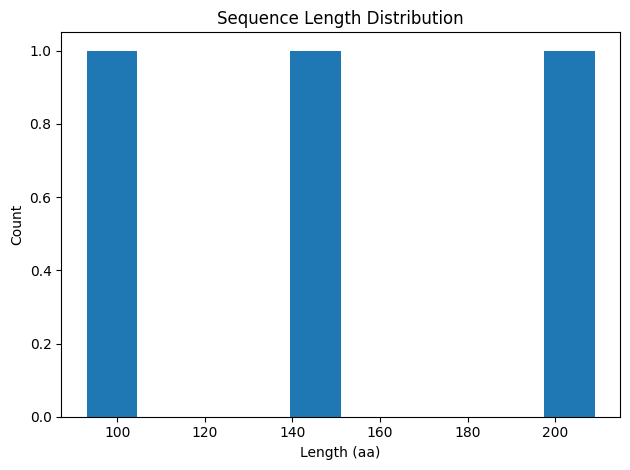

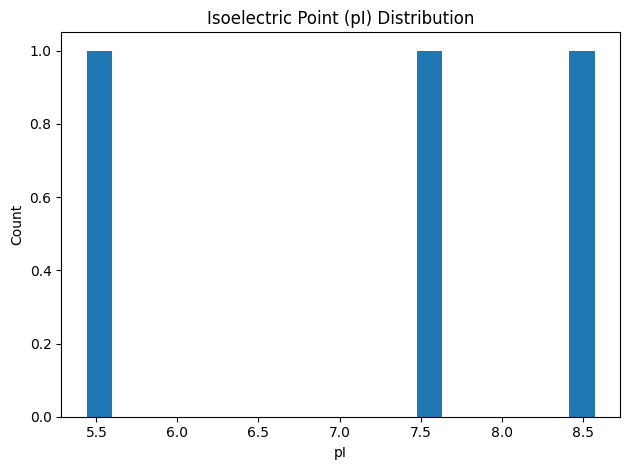

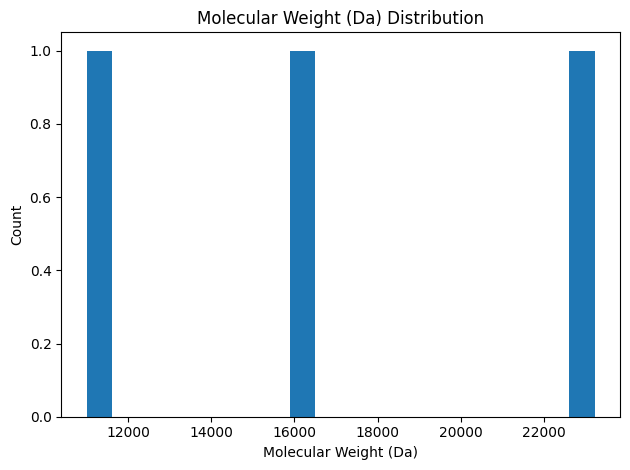

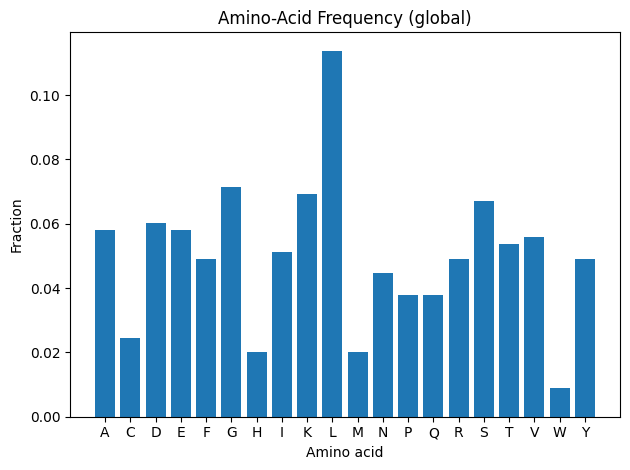

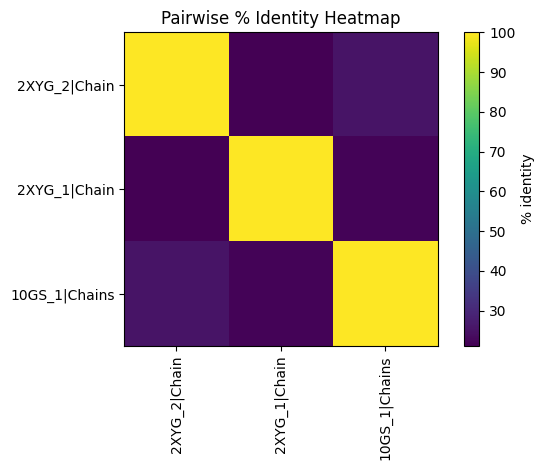

<Figure size 640x480 with 0 Axes>

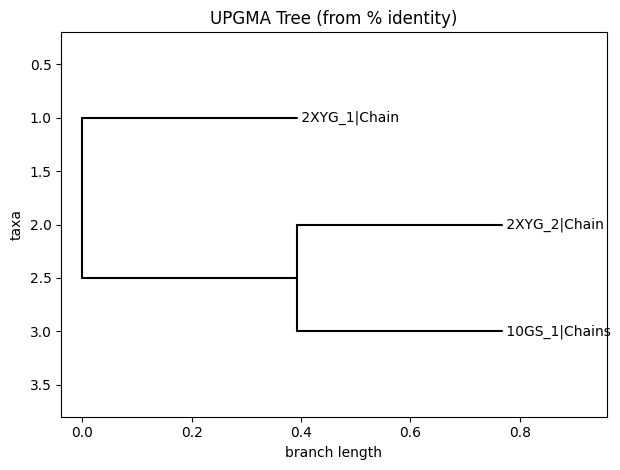

In [11]:
#Visualizes Outputs
FASTA_PATH_MAIN  = r"/content/drive/MyDrive/rcsb_pdb_2XYG.fasta"   # main FASTA (multi or single)
MIN_LENGTH = 20
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")
#Core helpers
def is_valid_protein(s: str) -> bool:
    return set(s) <= VALID_AA
def load_valid_sequences(path: str):
    """Load protein sequences (standard AAs only, length ≥ MIN_LENGTH)."""
    recs = []
    if not path:
        return recs
    p = Path(path)
    if not p.exists():
        print(f"⚠ Skipping (file not found): {p}")
        return recs
    for r in SeqIO.parse(str(p), "fasta"):
        s = str(r.seq).upper()
        if len(s) >= MIN_LENGTH and is_valid_protein(s):
            recs.append(SeqRecord(Seq(s), id=r.id, description=r.description))
    return recs
def analyze_features(records):
    """Return per-sequence features and aggregate amino-acid counts."""
    features = []
    aa_counter = Counter()
    for r in records:
        seq = str(r.seq)
        pa = ProteinAnalysis(seq)
        entry = {
            "id": r.id,
            "length": len(seq),
            "pI": pa.isoelectric_point(),
            "mw": pa.molecular_weight(),
        }
        features.append(entry)
        aa_counter.update(list(seq))
    return features, aa_counter
#Pairwise identity + UPGMA
def make_aligner() -> PairwiseAligner:
    A = PairwiseAligner()
    A.mode = "global"
    A.substitution_matrix = substitution_matrices.load("BLOSUM62")
    A.open_gap_score = -10
    A.extend_gap_score = -0.5
    return A
def reconstruct_aligned_strings(aln, a: str, b: str):
    """Build aligned strings from Alignment.aligned index blocks."""
    a_aln, b_aln = [], []
    i_prev, j_prev = 0, 0
    for (i0, i1), (j0, j1) in zip(aln.aligned[0], aln.aligned[1]):
        a_aln.append(a[i_prev:i0]);           b_aln.append("-" * (i0 - i_prev))
        a_aln.append("-" * (j0 - j_prev));    b_aln.append(b[j_prev:j0])
        a_aln.append(a[i0:i1]);               b_aln.append(b[j0:j1])
        i_prev, j_prev = i1, j1
    a_aln.append(a[i_prev:]);                 b_aln.append("-" * (len(a) - i_prev))
    a_aln.append("-" * (len(b) - j_prev));    b_aln.append(b[j_prev:])
    A = "".join(a_aln); B = "".join(b_aln)
    L = max(len(A), len(B))
    return A.ljust(L, "-"), B.ljust(L, "-")
def percent_identity(a_aln: str, b_aln: str) -> float:
    matches = sum(1 for x, y in zip(a_aln, b_aln) if x == y and x != "-")
    aligned = sum(1 for x, y in zip(a_aln, b_aln) if x != "-" and y != "-")
    return (100.0 * matches / aligned) if aligned else 0.0
def pairwise_identity_matrix(records):
    """Compute pairwise % identity matrix via global alignment."""
    n = len(records)
    ids = [r.id for r in records]
    mat = np.zeros((n, n), dtype=float)
    aligner = make_aligner()
    for i in range(n):
        mat[i, i] = 100.0
        for j in range(i + 1, n):
            a, b = str(records[i].seq), str(records[j].seq)
            aln = aligner.align(a, b)[0]
            aA, bA = reconstruct_aligned_strings(aln, a, b)
            pid = percent_identity(aA, bA)
            mat[i, j] = mat[j, i] = pid
    return mat, ids
def upgma_newick(ids, pid_matrix: np.ndarray) -> str:
    n = len(ids)
    active = {i: (ids[i], 1, {i}) for i in range(n)}  # id -> (newick, size, leaves)
    # cache distances
    dist = {}
    for i in range(n):
        for j in range(i + 1, n):
            dist[(i, j)] = 1.0 - pid_matrix[i, j] / 100.0
    def avg_dist(a_leaves, b_leaves):
        vals = []
        for i in a_leaves:
            for j in b_leaves:
                x, y = (i, j) if i < j else (j, i)
                vals.append(dist[(x, y)])
        return sum(vals) / len(vals) if vals else 0.0
    next_key = n
    keys = list(active.keys())
    while len(keys) > 1:
        # find closest pair
        best = None
        best_d = float("inf")
        for i_idx in range(len(keys)):
            for j_idx in range(i_idx + 1, len(keys)):
                i, j = keys[i_idx], keys[j_idx]
                di = avg_dist(active[i][2], active[j][2])
                if di < best_d:
                    best_d, best = di, (i, j)
        i, j = best
        niw, ni, li = active[i]
        njw, nj, lj = active[j]
        # approximate equal branch lengths from cluster distance
        neww = f"({niw}:{best_d/2:.3f},{njw}:{best_d/2:.3f})"
        active[next_key] = (neww, ni + nj, li | lj)
        # remove merged
        del active[i]; del active[j]
        keys = [k for k in keys if k not in (i, j)]
        keys.append(next_key)
        next_key += 1
    root = active[keys[0]][0] + ";"
    return root
#Plotting helpers
def plot_length_hist(lengths):
    plt.figure()
    plt.hist(lengths, bins=max(10, min(50, len(set(lengths)))))
    plt.title("Sequence Length Distribution")
    plt.xlabel("Length (aa)")
    plt.ylabel("Count")
    plt.tight_layout()
def plot_pi_hist(pis):
    plt.figure()
    plt.hist(pis, bins=20)
    plt.title("Isoelectric Point (pI) Distribution")
    plt.xlabel("pI")
    plt.ylabel("Count")
    plt.tight_layout()
def plot_mw_hist(mws):
    plt.figure()
    plt.hist(mws, bins=20)
    plt.title("Molecular Weight (Da) Distribution")
    plt.xlabel("Molecular Weight (Da)")
    plt.ylabel("Count")
    plt.tight_layout()
def plot_aa_bar(aa_counter):
    # Normalize to frequency
    total = sum(aa_counter[a] for a in VALID_AA)
    aa = sorted(list(VALID_AA))
    freqs = [(aa_counter[a] / total) if total else 0.0 for a in aa]
    plt.figure()
    plt.bar(aa, freqs)
    plt.title("Amino-Acid Frequency (global)")
    plt.xlabel("Amino acid")
    plt.ylabel("Fraction")
    plt.tight_layout()
def plot_identity_heatmap(mat, ids):
    if len(ids) < 2:
        return
    plt.figure()
    plt.imshow(mat, interpolation="nearest")
    plt.colorbar(label="% identity")
    plt.xticks(range(len(ids)), ids, rotation=90)
    plt.yticks(range(len(ids)), ids)
    plt.title("Pairwise % Identity Heatmap")
    plt.tight_layout()
def plot_upgma_tree(newick_str):
    if not newick_str or newick_str.strip() == ";":
        return
    tree = Phylo.read(StringIO(newick_str), "newick")
    plt.figure()
    Phylo.draw(tree, do_show=False)  # use current matplotlib axes
    plt.title("UPGMA Tree (from % identity)")
    plt.tight_layout()
#Main
if __name__ == "__main__":
    # Load sequences
    main_recs  = load_valid_sequences(FASTA_PATH_MAIN)
    extra_recs = load_valid_sequences(FASTA_PATH_EXTRA)
    records    = main_recs + extra_recs
    if len(records) == 0:
        raise ValueError("No valid sequences found. Check FASTA paths or filters.")
    if len(records) == 1:
        print("⚠ Only one valid sequence found. Some plots (heatmap/tree) will be skipped.")
    print(f"Loaded {len(records)} sequences "
          f"({len(main_recs)} from main, {len(extra_recs)} from extra).")
    # Compute per-sequence features and global AA counts
    feats, aa_counter = analyze_features(records)
    lengths = [f["length"] for f in feats]
    pis     = [f["pI"] for f in feats]
    mws     = [f["mw"] for f in feats]
    # Identify quick clusters/outliers heuristically
    print("\nQuick stats:")
    print(f"- Mean length: {mean(lengths):.1f} aa")
    print(f"- Mean pI:     {mean(pis):.2f}")
    print(f"- Mean MW:     {mean(mws):.1f} Da")
    # Outliers (very rough): outside mean ± 2*std (length)
    if len(lengths) >= 3:
        L = np.array(lengths, dtype=float)
        mu, sd = L.mean(), L.std(ddof=1)
        out_idx = np.where((L < mu - 2*sd) | (L > mu + 2*sd))[0].tolist()
        if out_idx:
            print("- Outlier(s) by length:", [records[i].id for i in out_idx])
    # Pairwise identity matrix and UPGMA (if ≥2 sequences)
    pid_matrix, ids = (None, None)
    newick = ""
    if len(records) >= 2:
        pid_matrix, ids = pairwise_identity_matrix(records)
        newick = upgma_newick(ids, pid_matrix)
    #Plots
    plot_length_hist(lengths)
    plot_pi_hist(pis)
    plot_mw_hist(mws)
    plot_aa_bar(aa_counter)
    if pid_matrix is not None:
        plot_identity_heatmap(pid_matrix, ids)
        plot_upgma_tree(newick)
    # Show all figures
    plt.show()


In [12]:
#Annotates Genomes / Proteins
FASTA_PATH = r"/content/drive/MyDrive/rcsb_pdb_2XYG.fasta"  # <-- set your FASTA file path
MIN_LENGTH = 20
#Valid amino acids (20)
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")
def is_valid_protein(seq: str) -> bool:
    return set(seq.upper()) <= VALID_AA
#Kyte–Doolittle hydropathy scores
KD = {
    'I': 4.5, 'V': 4.2, 'L': 3.8, 'F': 2.8, 'C': 2.5, 'M': 1.9, 'A': 1.8, 'G': -0.4,
    'T': -0.7, 'S': -0.8, 'W': -0.9, 'Y': -1.3, 'P': -1.6, 'H': -3.2, 'E': -3.5,
    'Q': -3.5, 'D': -3.5, 'N': -3.5, 'K': -3.9, 'R': -4.5
}
def kd_window_mean(seq: str, start: int, size: int) -> float:
    """Mean KD score over a window (seq must be uppercase and valid AAs)."""
    window = seq[start:start+size]
    return sum(KD[a] for a in window) / len(window)
def find_tm_helices(seq: str, win: int = 19, thr: float = 1.6, min_sep: int = 5):
    seq = seq.upper()
    n = len(seq)
    hits = []
    i = 0
    while i + win <= n:
        avg = kd_window_mean(seq, i, win)
        if avg >= thr:
            # extend contiguously while KD remains high (soft merge)
            j = i + win
            while j + win <= n and kd_window_mean(seq, j, win) >= thr:
                j += 1
            # report a single helix spanning i..j+win-1 (merge block)
            start = i + 1
            end = j + win
            helix_avg = kd_window_mean(seq, i, min(win, n - i))
            hits.append((start, end, helix_avg))
            i = j + min_sep
        else:
            i += 1
    return hits
#Signal peptide heuristic
HYDRO_SET = set("AVILMFWYC")
def has_signal_peptide(seq: str) -> dict:
    n = min(30, len(seq))
    nterm = seq[:n]
    # (a) hydrophobic segment
    hpos = None
    for i in range(0, max(1, n - 10)):
        window = nterm[i:i+11]
        if sum(aa in HYDRO_SET for aa in window) >= 8:
            hpos = (i + 1, i + 11)  # 1-based
            break
    # (b) AXA motif ~ 15–30
    axa_pos = None
    for i in range(14, min(n-1, 29)):
        if nterm[i] == 'A' and nterm[i+2:i+3] == 'A':
            axa_pos = i + 1  # 1-based index of first 'A'
            break
    present = (hpos is not None) and (axa_pos is not None)
    return {"present": present, "hpos": hpos, "axa_pos": axa_pos}
# --- Motif regex helpers (PROSITE-like to regex for a few patterns) ---
def prosite_to_regex(pattern: str) -> str:
    s = pattern.replace("-", "")
    s = re.sub(r"x\((\d+)\)", r".{\1}", s, flags=re.IGNORECASE)
    s = re.sub(r"x", r".", s, flags=re.IGNORECASE)
    s = re.sub(r"\{([A-Z]+)\}", r"[^\1]", s)
    return s
# Pre-compile motifs
MOTIFS = {
    # name: (type, regex/pattern, description)
    "N_glycosylation": ("prosite", "N-{P}-[ST]-{P}", "N{P}[ST]{P} (NXS/T, X!=P)"),
    "Proline_phospho": ("regex", r"[ST]P", "Proline-directed phosphorylation [ST]P"),
    "NLS_mono": ("regex", r"K[KR].[KR]", "Monopartite NLS (simplified)"),
    "P_loop_WalkerA": ("prosite", "G-x(4)-G-K-[ST]", "P-loop NTPase Walker A"),
    "Lipase_GxSxG": ("prosite", "G-x-S-x-G", "Lipase/esterase nucleophile"),
    "Metalloprotease_HExH": ("prosite", "H-E-x-H", "Metalloprotease HExH"),
}
compiled = {}
for name, (kind, patt, _) in MOTIFS.items():
    if kind == "prosite":
        rx = prosite_to_regex(patt)
        compiled[name] = re.compile(rx)
    else:
        compiled[name] = re.compile(patt)
def find_motifs(seq: str):
    """Return dict: motif_name -> list of (start,end,match_string) 1-based."""
    hits = {}
    for name, rx in compiled.items():
        matches = []
        for m in rx.finditer(seq):
            s, e = m.start() + 1, m.end()
            matches.append((s, e, seq[m.start():m.end()]))
        hits[name] = matches
    return hits
def enzyme_hint(motif_hits: dict) -> str:
    """Heuristic functional hint: enzyme if catalytic-like motif present."""
    catalytic_like = {"P_loop_WalkerA", "Lipase_GxSxG", "Metalloprotease_HExH"}
    found = [k for k in catalytic_like if motif_hits.get(k)]
    if found:
        return "Likely enzyme (catalytic motif: " + ", ".join(found) + ")"
    return "Likely structural/other"
#Load sequences
def load_sequences(fasta_path: str):
    recs = []
    for rec in SeqIO.parse(fasta_path, "fasta"):
        s = str(rec.seq).upper()
        if len(s) >= MIN_LENGTH and is_valid_protein(s):
            recs.append(SeqRecord(Seq(s), id=rec.id, description=rec.description))
    return recs
#Per-protein annotation
def annotate_protein(rec: SeqRecord):
    seq = str(rec.seq)
    motifs = find_motifs(seq)
    sig = has_signal_peptide(seq)
    tms = find_tm_helices(seq, win=19, thr=1.6)
    func = enzyme_hint(motifs)
    # Active/catalytic sites (report motif coordinates succinctly)
    catalytic_spots = []
    for cat in ("P_loop_WalkerA", "Lipase_GxSxG", "Metalloprotease_HExH"):
        for (s, e, _) in motifs.get(cat, []):
            catalytic_spots.append((cat, s, e))
    return {
        "id": rec.id,
        "length": len(seq),
        "motifs": motifs,             # dict[name] -> list[(start,end,match)]
        "signal_peptide": sig,        # dict with present, hpos, axa_pos
        "tm_helices": tms,            # list of (start,end,mean_kd)
        "function_hint": func,
        "catalytic_spots": catalytic_spots
    }
#Summary aggregation
def summarize_annotations(annots: list):
    n = len(annots)
    tm_count = sum(1 for a in annots if a["tm_helices"])
    sp_count = sum(1 for a in annots if a["signal_peptide"]["present"])
    motif_totals = Counter()
    for a in annots:
        for name, matches in a["motifs"].items():
            motif_totals[name] += len(matches)
    enzyme_like = sum(1 for a in annots if a["function_hint"].startswith("Likely enzyme"))
    print("\nSUMMARY")
    print(f"Proteins analyzed: {n}")
    print(f"With predicted TM region(s): {tm_count}")
    print(f"With signal peptide (heuristic): {sp_count}")
    print(f"Likely enzyme (motif-based hint): {enzyme_like}")
    print("\nMotif totals:")
    for name, count in motif_totals.items():
        desc = MOTIFS[name][2]
        print(f" - {name:24s} : {count:3d}  ({desc})")
    # Show a few proteins with most motif hits
    motif_burden = []
    for a in annots:
        c = sum(len(v) for v in a["motifs"].values())
        motif_burden.append((c, a["id"]))
    motif_burden.sort(reverse=True)
    top = motif_burden[:5]
    if top:
        print("\nTop proteins by motif count:")
        for c, pid in top:
            print(f" - {pid}: {c} motifs")
#Pretty printing per protein
def print_annotation(a: dict):
    print("\n")
    print(f"ID: {a['id']} | length: {a['length']} aa")
    # Signal peptide
    sp = a["signal_peptide"]
    if sp["present"]:
        print(f"Signal peptide: YES  hydrophobic={sp['hpos']}  AXA@{sp['axa_pos']}")
    else:
        print("Signal peptide: no")
    # TM helices
    if a["tm_helices"]:
        print(f"TM helices ({len(a['tm_helices'])}): " + ", ".join(
            f"{s}-{e}(avgKD={kd:.2f})" for (s, e, kd) in a["tm_helices"]
        ))
    else:
        print("TM helices: none")
    # Motifs
    print("Motifs:")
    for name, matches in a["motifs"].items():
        if matches:
            loci = ", ".join(f"{s}-{e}:{m}" for (s, e, m) in matches[:8])
            more = " ..." if len(matches) > 8 else ""
            print(f"  - {name}: {len(matches)} hit(s) [{loci}{more}]")
    # Functional hint & catalytic spots
    print("Function hint:", a["function_hint"])
    if a["catalytic_spots"]:
        detail = ", ".join(f"{tag}@{s}-{e}" for (tag, s, e) in a["catalytic_spots"][:6])
        more = " ..." if len(a["catalytic_spots"]) > 6 else ""
        print("Catalytic spots:", detail + more)
if __name__ == "__main__":
    p = Path(FASTA_PATH)
    if not p.exists():
        raise FileNotFoundError(
            f"FASTA file not found: {p}\n"
            "→ Set FASTA_PATH to your protein FASTA."
        )
    records = []
    for rec in SeqIO.parse(str(p), "fasta"):
        s = str(rec.seq).upper()
        if len(s) >= MIN_LENGTH and is_valid_protein(s):
            records.append(SeqRecord(Seq(s), id=rec.id, description=rec.description))
    if not records:
        raise ValueError("No valid protein sequences found (check length/characters).")
    print(f"Loaded {len(records)} protein sequence(s) from {p.resolve()}")
    # Annotate all proteins
    annotations = [annotate_protein(r) for r in records]
    # Per-protein printout
    for a in annotations:
        print_annotation(a)
    # Global summary
    summarize_annotations(annotations)

Loaded 2 protein sequence(s) from /content/drive/MyDrive/rcsb_pdb_2XYG.fasta


ID: 2XYG_2|Chain | length: 93 aa
Signal peptide: no
TM helices: none
Motifs:
Function hint: Likely structural/other


ID: 2XYG_1|Chain | length: 146 aa
Signal peptide: no
TM helices: none
Motifs:
Function hint: Likely structural/other

SUMMARY
Proteins analyzed: 2
With predicted TM region(s): 0
With signal peptide (heuristic): 0
Likely enzyme (motif-based hint): 0

Motif totals:
 - N_glycosylation          :   0  (N{P}[ST]{P} (NXS/T, X!=P))
 - Proline_phospho          :   0  (Proline-directed phosphorylation [ST]P)
 - NLS_mono                 :   0  (Monopartite NLS (simplified))
 - P_loop_WalkerA           :   0  (P-loop NTPase Walker A)
 - Lipase_GxSxG             :   0  (Lipase/esterase nucleophile)
 - Metalloprotease_HExH     :   0  (Metalloprotease HExH)

Top proteins by motif count:
 - 2XYG_2|Chain: 0 motifs
 - 2XYG_1|Chain: 0 motifs


In [13]:
#Accesses Biological Databases
PDB_IDS = ["2XYG"]
DOWNLOAD_DIR = "pdb_cifs"
FETCH_UNIPROT = True
def download_cif(pdb_id: str) -> Path:
    outdir = Path(DOWNLOAD_DIR)
    outdir.mkdir(parents=True, exist_ok=True)
    pdbl = PDBList()
    # Returns a .cif or .cif.gz path (both parsers can handle gz)
    cif_path = pdbl.retrieve_pdb_file(pdb_id, pdir=str(outdir), file_format="mmCif")
    return Path(cif_path)
def _first_val(d: MMCIF2Dict.MMCIF2Dict, key: str) -> Optional[str]:
    val = d.get(key)
    if val is None:
        return None
    if isinstance(val, list):
        return val[0]
    return val
def parse_cif_metadata(cif_file: Path) -> Dict:
    d = MMCIF2Dict.MMCIF2Dict(str(cif_file))
    title = _first_val(d, "_struct.title")
    method = _first_val(d, "_exptl.method")
    resolution = _first_val(d, "_refine.ls_d_res_high")  # may be None for NMR
    # UniProt cross-refs often live in struct_ref with db_name 'UNP' or 'UniProt'
    db_names = d.get("_struct_ref.db_name", [])
    db_accs  = d.get("_struct_ref.pdbx_db_accession", [])
    uniprot_ids = []
    if db_names and db_accs:
        # ensure lists
        if not isinstance(db_names, list): db_names = [db_names]
        if not isinstance(db_accs, list):  db_accs  = [db_accs]
        for n, a in zip(db_names, db_accs):
            if str(n).upper().startswith("UNP") and a not in (None, "?", ""):
                uniprot_ids.append(a.strip())
    # Organism (if available) from entity_src categories
    organisms = set()
    for k in (
        "_entity_src_gen.pdbx_gene_src_scientific_name",
        "_entity_src_gen.pdbx_organism_scientific",
        "_entity_src_nat.pdbx_organism_scientific",
    ):
        vals = d.get(k, [])
        if not isinstance(vals, list):
            vals = [vals]
        for v in vals:
            if v and v != "?":
                organisms.add(v)
    return {
        "title": title,
        "method": method,
        "resolution": resolution,
        "uniprot": sorted(set(uniprot_ids)),
        "organisms": sorted(organisms),
    }
def extract_chain_sequences(cif_file: Path) -> Dict[str, Dict]:
    parser = MMCIFParser(QUIET=True)
    structure_id = cif_file.stem.upper()
    structure = parser.get_structure(structure_id, str(cif_file))
    ppb = PPBuilder()
    chain_map: Dict[str, Dict] = {}
    # Use first model (common for X-ray); extend if you need all models
    model = next(structure.get_models())
    for chain in model:
        peptides = ppb.build_peptides(chain)
        if not peptides:
            continue
        seq = "".join(str(pp.get_sequence()) for pp in peptides)
        if seq:
            chain_map[chain.id] = {"sequence": seq, "length": len(seq)}
    return chain_map
def fetch_uniprot(uniprot_acc: str) -> Dict:
    try:
        handle = ExPASy.get_sprot_raw(uniprot_acc)
        record = SwissProt.read(handle)
    except Exception as e:
        return {"error": f"UniProt fetch failed for {uniprot_acc}: {e}"}
    # KEGG cross-refs
    kegg = [xref[1] for xref in record.cross_references if xref[0].upper() == "KEGG"]
    return {
        "uniprot": uniprot_acc,
        "description": record.description,
        "organism": record.organism,
        "taxonomy": record.organism_classification[:6],
        "keywords": record.keywords[:10],
        "kegg": kegg,
        "seq_length": record.sequence_length,
    }
def print_interpretation(method: Optional[str], resolution: Optional[str], chains: Dict[str, Dict]):
    print("\nBiological Insights:")
    if method:
        m = method.upper()
        if "XRAY" in m or "X-RAY" in m:
            print("Determined by X-ray crystallography — good atomic detail.")
        elif "NMR" in m:
            print("NMR structure — ensemble may reflect conformational variability.")
        elif "EM" in m:
            print("Electron microscopy — good for large complexes.")
        else:
            print(f"Method: {method}")
    if resolution and resolution != "?":
        try:
            r = float(resolution)
            if r < 2.0:
                print("High resolution (<2.0 Å) — fine atomic accuracy.")
            elif r <= 3.0:
                print(f"Moderate resolution ({r:.2f} Å) — backbone confident, side chains fair.")
            else:
                print(f"Lower resolution ({r:.2f} Å) — overall fold; side chains uncertain.")
        except:
            pass
    if chains:
        largest = max(chains.items(), key=lambda kv: kv[1]["length"])
        print(f"Largest chain: {largest[0]} ({largest[1]['length']} aa) — likely core domain.")
def print_pdb_report(pdb_id: str):
    print("\n" + "=" * 74)
    print(f"PDB Entry: {pdb_id.upper()}")
    cif = download_cif(pdb_id)
    meta = parse_cif_metadata(cif)
    chains = extract_chain_sequences(cif)
    print(f"Title           : {meta['title'] or '—'}")
    print(f"Method          : {meta['method'] or '—'}")
    print(f"Resolution (Å)  : {meta['resolution'] or '—'}")
    if meta["organisms"]:
        print(f"Organism(s)     : {', '.join(meta['organisms'])}")
    print("\nProtein Chains:")
    if chains:
        for cid, info in chains.items():
            print(f"Chain {cid}: {info['length']} aa")
    else:
        print("No protein chains with parsable sequences were found.")
    if meta["uniprot"]:
        print("\nUniProt Mapping:")
        for acc in meta["uniprot"]:
            print(f"   {acc}")
    else:
        print("\nUniProt Mapping: —")
    if FETCH_UNIPROT and meta["uniprot"]:
        print("\nFunctional Annotation (UniProt):")
        for acc in meta["uniprot"][:3]:  # keep it concise
            ann = fetch_uniprot(acc)
            if "error" in ann:
                print(f"  {acc}: {ann['error']}")
                continue
            print(f"\n   {acc}")
            print(f"     Description : {ann['description']}")
            print(f"     Organism    : {ann['organism']}")
            if ann["taxonomy"]:
                print(f"     Taxonomy    : {' > '.join(ann['taxonomy'])}")
            if ann["keywords"]:
                print(f"     Keywords    : {', '.join(ann['keywords'])}")
            print(f"     KEGG        : {', '.join(ann['kegg']) if ann['kegg'] else '—'}")
            print(f"     Seq length  : {ann['seq_length']} aa")
    print_interpretation(meta["method"], meta["resolution"], chains)
    print("=" * 74)
if __name__ == "__main__":
    if not PDB_IDS:
        raise ValueError("Please set PDB_IDS to a list of PDB codes.")
    for pid in PDB_IDS:
        try:
            print_pdb_report(pid)
        except Exception as e:
            print(f"\nError for {pid}: {e}")



PDB Entry: 2XYG
Title           : Caspase-3:CAS329306
Method          : X-RAY DIFFRACTION
Resolution (Å)  : 1.54
Organism(s)     : HOMO SAPIENS

Protein Chains:
Chain A: 146 aa
Chain B: 93 aa

UniProt Mapping:
   P42574

Functional Annotation (UniProt):

   P42574
     Description : RecName: Full=Caspase-3 {ECO:0000303|PubMed:15003516, ECO:0000303|PubMed:18723680}; Short=CASP-3; EC=3.4.22.56 {ECO:0000269|PubMed:23152800, ECO:0000269|PubMed:23845944, ECO:0000269|PubMed:30878284, ECO:0000269|PubMed:33725486, ECO:0000269|PubMed:7596430}; AltName: Full=Apopain {ECO:0000303|PubMed:8696339}; AltName: Full=Cysteine protease CPP32 {ECO:0000303|PubMed:7774019}; Short=CPP-32 {ECO:0000303|PubMed:7774019, ECO:0000303|PubMed:9334240}; AltName: Full=Protein Yama {ECO:0000303|PubMed:7774019}; AltName: Full=SREBP cleavage activity 1; Short=SCA-1; Contains: RecName: Full=Caspase-3 subunit p17; Contains: RecName: Full=Caspase-3 subunit p12; Flags: Precursor;
     Organism    : Homo sapiens (Human).
   

In [14]:
#Functional classification
PDB_IDS = ["2XYG"]
DOWNLOAD_DIR = "pdb_cifs"
SCAN_MOTIFS = True
MIN_CHAIN_LEN = 30
# (PROSITE-like patterns converted to regex)
MOTIF_PATTERNS = {
    "P-loop_NTPase_WalkerA": r"G....GK[ST]",     # GxxxxGK[ST]
    "Lipase_GxSxG":          r"G.S.G",           # GxSxG
    "Metalloprotease_HExH":  r"HE.H",            # HExH
    "Cys_Protease_CysHis":   r"C.{2,4}H",        # crude Cys-His dyad
}
MOTIF_COMPILED = {k: re.compile(v) for k, v in MOTIF_PATTERNS.items()}
#Utilities: PDB/mmCIF
def download_cif(pdb_id: str) -> Path:
    outdir = Path(DOWNLOAD_DIR)
    outdir.mkdir(parents=True, exist_ok=True)
    pdbl = PDBList()
    cif_path = pdbl.retrieve_pdb_file(pdb_id, pdir=str(outdir), file_format="mmCif")
    return Path(cif_path)
def parse_cif_metadata(cif: Path) -> Dict:
    d = MMCIF2Dict.MMCIF2Dict(str(cif))
    def first(key: str) -> Optional[str]:
        v = d.get(key)
        return v[0] if isinstance(v, list) else v
    title = first("_struct.title")
    method = first("_exptl.method")
    resolution = first("_refine.ls_d_res_high")
    # UniProt xrefs (struct_ref)
    db_names = d.get("_struct_ref.db_name", [])
    db_accs  = d.get("_struct_ref.pdbx_db_accession", [])
    uniprot = []
    if db_names and db_accs:
        if not isinstance(db_names, list): db_names = [db_names]
        if not isinstance(db_accs, list):  db_accs  = [db_accs]
        for n, a in zip(db_names, db_accs):
            if str(n).upper().startswith("UNP") and a not in (None, "?", ""):
                uniprot.append(a.strip())
    return {
        "title": title,
        "method": method,
        "resolution": resolution,
        "uniprot": sorted(set(uniprot)),
    }
def extract_chains(cif: Path) -> Dict[str, Dict]:
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure(cif.stem.upper(), str(cif))
    ppb = PPBuilder()
    chain_map: Dict[str, Dict] = {}
    model = next(structure.get_models())  # first model
    for chain in model:
        peptides = ppb.build_peptides(chain)
        if not peptides:
            continue
        seq = "".join(str(pp.get_sequence()) for pp in peptides)
        if seq:
            chain_map[chain.id] = {"length": len(seq), "sequence": seq}
    return chain_map
#UniProt (Swiss-Prot) via Biopython
def fetch_swissprot(uniprot_acc: str) -> Dict:
    try:
        handle = ExPASy.get_sprot_raw(uniprot_acc)
        rec = SwissProt.read(handle)
    except Exception as e:
        return {"error": f"UniProt fetch failed for {uniprot_acc}: {e}"}
    xrefs = defaultdict(list)
    for db, *rest in rec.cross_references:
        xrefs[db].append(rest)  # keep raw tuples minus db name
    # Extract helpful summaries
    pfam = [{"acc": r[0], "name": (r[1] if len(r) > 1 else "")} for r in xrefs.get("Pfam", [])]
    interpro = [{"acc": r[0], "name": (r[1] if len(r) > 1 else "")} for r in xrefs.get("InterPro", [])]
    prosite = [{"acc": r[0], "name": (r[1] if len(r) > 1 else "")} for r in xrefs.get("PROSITE", [])]
    ec_nums = [r[0] for r in xrefs.get("EC", []) if r and r[0] != "-"]
    go_terms = [r[0] for r in xrefs.get("GO", [])]
    return {
        "uniprot": uniprot_acc,
        "description": rec.description,
        "organism": rec.organism,
        "keywords": rec.keywords,
        "pfam": pfam,
        "interpro": interpro,
        "prosite": prosite,
        "ec": ec_nums,
        "go": go_terms,
    }
#Simple functional classifier
def infer_enzyme_class_from_ec(ec_list: List[str]) -> Optional[str]:
    if not ec_list:
        return None
    first = ec_list[0].split(".")[0]
    mapping = {
        "1": "Oxidoreductase",
        "2": "Transferase",
        "3": "Hydrolase",
        "4": "Lyase",
        "5": "Isomerase",
        "6": "Ligase",
        "7": "Translocase",
    }
    return mapping.get(first, f"Enzyme (EC {ec_list[0]})")
def pick_domain_labels(pfam: List[Dict], interpro: List[Dict], limit: int = 3) -> List[str]:
    names = [d["name"] for d in interpro if d.get("name")] + [d["name"] for d in pfam if d.get("name")]
    # remove duplicates, keep order
    seen, picked = set(), []
    for n in names:
        if n not in seen:
            picked.append(n)
            seen.add(n)
        if len(picked) >= limit:
            break
    return picked
def motif_hints(seq: str) -> List[str]:
    if not SCAN_MOTIFS or len(seq) < MIN_CHAIN_LEN:
        return []
    seq = seq.upper()
    hits = []
    for name, rx in MOTIF_COMPILED.items():
        if rx.search(seq):
            hits.append(name)
    return hits
def classify_function(uniprot_ann: Dict, chain_seqs: Dict[str, Dict]) -> Dict:
    ec = uniprot_ann.get("ec", [])
    is_enzyme = len(ec) > 0
    enzyme_class = infer_enzyme_class_from_ec(ec) if is_enzyme else None
    domains = pick_domain_labels(uniprot_ann.get("pfam", []), uniprot_ann.get("interpro", []), limit=3)
    # motif scanning on each chain sequence
    chain_motifs = {}
    for cid, info in chain_seqs.items():
        chain_motifs[cid] = motif_hints(info["sequence"])
    # keep a few informative keywords
    kws = uniprot_ann.get("keywords", [])[:10]
    return {
        "is_enzyme": is_enzyme,
        "enzyme_class": enzyme_class,
        "domain_labels": domains,
        "motif_hints": chain_motifs,
        "keywords": kws,
    }
def print_pdb_header(pdb_id: str, meta: Dict, chains: Dict[str, Dict]):
    print("\n" + "=" * 78)
    print(f"PDB: {pdb_id.upper()}")
    print(f"Title          : {meta.get('title') or '—'}")
    print(f"Method         : {meta.get('method') or '—'}")
    print(f"Resolution (Å) : {meta.get('resolution') or '—'}")
    print("\nChains:")
    if chains:
        for cid, info in chains.items():
            print(f"Chain {cid}: {info['length']} aa")
    else:
        print("No protein chains with parsable sequences.")

def print_uniprot_block(uniprot_acc: str, ann: Dict, classification: Dict):
    if "error" in ann:
        print(f"\nUniProt {uniprot_acc}: {ann['error']}")
        return
    print(f"\nUniProt: {uniprot_acc}")
    print(f"   Description : {ann.get('description','—')}")
    print(f"   Organism    : {ann.get('organism','—')}")
    if ann.get("ec"):
        print(f"   EC          : {', '.join(ann['ec'])}")
    if ann.get("pfam"):
        names = [d['name'] for d in ann['pfam'] if d.get('name')]
        print(f"   Pfam        : {', '.join(names) if names else '—'}")
    if ann.get("interpro"):
        names = [d['name'] for d in ann['interpro'] if d.get('name')]
        print(f"   InterPro    : {', '.join(names) if names else '—'}")
    if ann.get("prosite"):
        names = [d['name'] for d in ann['prosite'] if d.get('name')]
        print(f"   PROSITE     : {', '.join(names) if names else '—'}")
    # Classification summary
    print("\nFunctional Classification:")
    if classification["is_enzyme"]:
        print(f"Class      : {classification['enzyme_class']}")
    else:
        print("Class      : Non-enzyme / structural/binding")
    if classification["domain_labels"]:
        print(f"Domains    : {', '.join(classification['domain_labels'])}")
    if classification["keywords"]:
        print(f"Keywords   : {', '.join(classification['keywords'])}")
    # Motif hints per chain
    any_motifs = any(classification["motif_hints"].values())
    if any_motifs:
        print("Motif hints:")
        for cid, hits in classification["motif_hints"].items():
            if hits:
                print(f"       - Chain {cid}: {', '.join(hits)}")
def print_summary(summary_rows: List[Tuple[str, str, str]]):
    # rows: (PDB, UniProt, Classification string)
    if not summary_rows:
        return
    print("\n" + "-" * 78)
    print("Summary:")
    for pdb_id, acc, cls in summary_rows:
        print(f"  {pdb_id.upper():6s} | {acc:12s} | {cls}")
    print("-" * 78)
if __name__ == "__main__":
    if not PDB_IDS:
        raise ValueError("Please set PDB_IDS to a list of PDB codes.")
    summary = []
    for pdb in PDB_IDS:
        try:
            cif = download_cif(pdb)
            meta = parse_cif_metadata(cif)
            chains = extract_chains(cif)
            print_pdb_header(pdb, meta, chains)
            if not meta["uniprot"]:
                print("\n(No UniProt mapping found in PDB — cannot classify via Swiss-Prot.)")
                continue
            for acc in meta["uniprot"]:
                ann = fetch_swissprot(acc)
                cls = classify_function(ann if "error" not in ann else {}, chains)
                # Render report block
                print_uniprot_block(acc, ann, cls)
                # Build a compact one-line summary
                if "error" in ann:
                    cls_str = "Uniprot fetch failed"
                else:
                    if cls["is_enzyme"]:
                        cls_str = cls["enzyme_class"] or "Enzyme"
                    else:
                        # Prefer domain labels for non-enzymes
                        cls_str = ", ".join(cls["domain_labels"]) or "Non-enzyme"
                summary.append((pdb, acc, cls_str))
        except Exception as e:
            print(f"\nError for {pdb}: {e}")
    print_summary(summary)

Structure exists: 'pdb_cifs/2xyg.cif' 

PDB: 2XYG
Title          : Caspase-3:CAS329306
Method         : X-RAY DIFFRACTION
Resolution (Å) : 1.54

Chains:
Chain A: 146 aa
Chain B: 93 aa

UniProt: P42574
   Description : RecName: Full=Caspase-3 {ECO:0000303|PubMed:15003516, ECO:0000303|PubMed:18723680}; Short=CASP-3; EC=3.4.22.56 {ECO:0000269|PubMed:23152800, ECO:0000269|PubMed:23845944, ECO:0000269|PubMed:30878284, ECO:0000269|PubMed:33725486, ECO:0000269|PubMed:7596430}; AltName: Full=Apopain {ECO:0000303|PubMed:8696339}; AltName: Full=Cysteine protease CPP32 {ECO:0000303|PubMed:7774019}; Short=CPP-32 {ECO:0000303|PubMed:7774019, ECO:0000303|PubMed:9334240}; AltName: Full=Protein Yama {ECO:0000303|PubMed:7774019}; AltName: Full=SREBP cleavage activity 1; Short=SCA-1; Contains: RecName: Full=Caspase-3 subunit p17; Contains: RecName: Full=Caspase-3 subunit p12; Flags: Precursor;
   Organism    : Homo sapiens (Human).
   Pfam        : Peptidase_C14
   InterPro    : Caspase-like_dom_sf, Cas

In [15]:
from Bio.PDB import PDBList
from Bio.PDB import PDBParser
from Bio.PDB import PPBuilder
from Bio.PDB import is_aa

In [16]:
from Bio.PDB import PDBList, PDBParser, PPBuilder, is_aa

pid = input("PDB ID: ").strip().lower()
path = PDBList().retrieve_pdb_file(pid, file_format="pdb", pdir=".")
model = next(PDBParser(QUIET=True).get_structure(pid, path).get_models())
ppb = PPBuilder()
chains = {c.id: sum(len(str(pp.get_sequence())) for pp in ppb.build_peptides(c)) for c in model if ppb.build_peptides(c)}
ligs = sorted({r.get_resname() for c in model for r in c if not is_aa(r, standard=True) and r.get_resname() != "HOH"})
atoms = sum(1 for c in model for r in c for _ in r.get_atoms())

print(f"Saved: {path}\nAtoms: {atoms}\nChains (aa): {', '.join(f'{k}:{v}' for k,v in chains.items()) or '—'}\nLigands: {', '.join(ligs) if ligs else '—'}")


PDB ID: 2XYG
Structure exists: './pdb2xyg.ent' 
Saved: ./pdb2xyg.ent
Atoms: 2377
Chains (aa): A:146, B:93
Ligands: TQ8


In [17]:
# Install once per runtime
!pip -q install biopython py3Dmol
from Bio.PDB import PDBList
import py3Dmol
pdb_id = input("Enter PDB ID: ").strip().lower()
# Download PDB using Biopython
pdb_path = PDBList().retrieve_pdb_file(pdb_id, file_format='pdb', pdir='.')
pdb_text = open(pdb_path, 'r').read()
# Visualize with py3Dmol
v = py3Dmol.view(width=900, height=600)
v.addModel(pdb_text, 'pdb')
v.setBackgroundColor('white')
# RCSB-like look:
v.setStyle({'cartoon': {'color':'spectrum'}})                                 # protein
v.addStyle({'hetflag':True, 'not':{'resn':'HOH'}}, {'stick': {'radius':0.18}}) # ligands
v.addStyle({'resn':'HOH'}, {'sphere': {'radius':0.6, 'opacity':0.5}})          # waters
v.zoomTo()
v.show()

Enter PDB ID: 2XYG
Structure exists: './pdb2xyg.ent' 


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [18]:
# Install once per runtime
!pip -q install biopython py3Dmol ipywidgets
from google.colab import output; output.enable_custom_widget_manager()
from Bio.PDB import PDBList
import py3Dmol, ipywidgets as W
# ---- UI ----
pdb_box   = W.Text(value="2XYG", description="PDB")
chain_box = W.Text(value="A",    description="Chain")
resno_box = W.IntText(value=0,   description="Res#")
show_poly      = W.Checkbox(True,  description="Polymer (cartoon)")
show_polybond  = W.Checkbox(False, description="Polymer bonds (sticks)")
show_lig       = W.Checkbox(True,  description="Ligands (sticks)")
show_wat       = W.Checkbox(True,  description="Water (spheres)")
show_otherhet  = W.Checkbox(False, description="Other HET (sticks)")
show_allbonds  = W.Checkbox(False, description="Show ALL bonds")
load_btn  = W.Button(description="Load / Update", button_style="primary")
out       = W.Output()
def render(_=None):
    with out:
        out.clear_output()
        pid = pdb_box.value.strip().lower()
        path = PDBList().retrieve_pdb_file(pid, file_format='pdb', pdir='.')
        pdb_txt = open(path).read()
        v = py3Dmol.view(width=900, height=600)
        v.addModel(pdb_txt, 'pdb')
        v.setBackgroundColor('white')
        # Base: nothing -> apply toggles
        if show_poly.value:
            v.setStyle({'protein':True}, {'cartoon':{'color':'spectrum'}})
        if show_polybond.value:
            v.addStyle({'protein':True}, {'stick':{'radius':0.18}})
        if show_lig.value:
            v.addStyle({'hetflag':True, 'not':{'resn':'HOH'}}, {'stick':{'radius':0.22}})
        if show_wat.value:
            v.addStyle({'resn':'HOH'}, {'sphere':{'radius':0.6,'opacity':0.5}})
        if show_otherhet.value:
            # highlight other non-water HET groups differently (thin sticks)
            v.addStyle({'hetflag':True, 'not':{'resn':'HOH'}}, {'stick':{'radius':0.12}})
        if show_allbonds.value:
            v.setStyle({}, {'stick':{'radius':0.18}})  # override: show all bonds
        # Highlight a specific amino acid if provided
        ch = chain_box.value.strip()
        rn = int(resno_box.value or 0)
        if ch and rn>0:
            v.addStyle({'chain':ch,'resi':rn,'protein':True}, {'stick':{'colorscheme':'magentaCarbon','radius':0.25}})
            v.addLabel(f"{ch}:{rn}", {'position':{'resi':rn,'chain':ch}, 'backgroundOpacity':0.6})
        v.zoomTo(); display(v.show())
load_btn.on_click(render)
display(W.VBox([
    W.HBox([pdb_box, chain_box, resno_box, load_btn]),
    W.HBox([show_poly, show_polybond, show_lig, show_wat]),
    W.HBox([show_otherhet, show_allbonds]),
    out
]))
# Auto-render once
render()

Enter PDB ID: 2XYG
Downloaded: 2XYG.cif

=== SUMMARY ===
Chains: ['A', 'B']
Ligands (non-water): ['TQ8']

Amino Acid Composition:
 S: 20 (8.4%)
 L: 19 (7.9%)
 K: 19 (7.9%)
 I: 16 (6.7%)
 E: 16 (6.7%)
 F: 15 (6.3%)
 T: 15 (6.3%)
 G: 14 (5.9%)
 D: 14 (5.9%)
 R: 14 (5.9%)
 N: 12 (5.0%)
 V: 11 (4.6%)
 A: 11 (4.6%)
 Y: 10 (4.2%)
 M: 7 (2.9%)
 C: 7 (2.9%)
 H: 7 (2.9%)
 P: 6 (2.5%)
 Q: 4 (1.7%)
 W: 2 (0.8%)

Missing segments:
 None (via residue numbering)

Plotting 3D backbone…


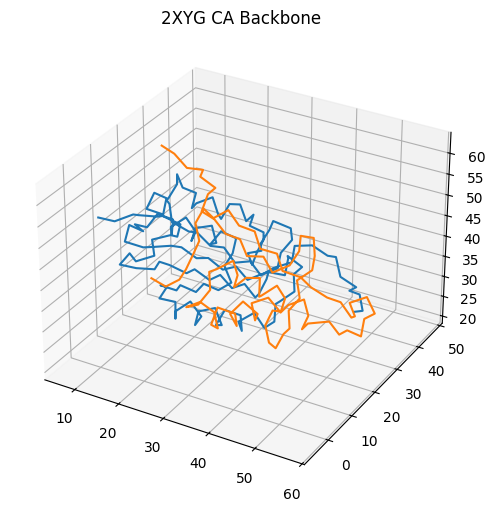

In [19]:
import urllib.request, os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from Bio.PDB import MMCIFParser, PPBuilder
from Bio.Data.IUPACData import protein_letters_3to1
# Build 3-letter → 1-letter dictionary
aa3to1 = {k.upper(): v for k,v in protein_letters_3to1.items()}
# Nonstandard → X
def to1(resname):
    return aa3to1.get(resname.upper(), 'X')
#Input & download
pdb_id = input("Enter PDB ID: ").strip().upper() or "2XYG"
cif_url = f"https://files.rcsb.org/download/{pdb_id}.cif"
cif_path = f"{pdb_id}.cif"
urllib.request.urlretrieve(cif_url, cif_path)
print(f"Downloaded: {cif_path}")
#Parse structure
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)
chains=[]
ligands=set()
aa_comp=Counter()
missing={}
for model in structure:
    for chain in model:
        residues=[r for r in chain.get_residues()]
        if not residues: continue
        chains.append(chain.id)
        aa_res=[r for r in residues if r.id[0]==' ']
        seq=''.join(to1(r.resname) for r in aa_res)
        aa_comp.update(seq)
        for r in residues:
            if r.id[0] != ' ' and r.resname != "HOH":
                ligands.add(r.resname)
        ids=[r.id[1] for r in aa_res]
        gaps=[]
        if ids:
            prev=ids[0]
            for n in ids[1:]:
                if n>prev+1:
                    gaps.append((prev+1,n-1))
                prev=n
        missing[chain.id]=gaps
print("\n=== SUMMARY ===")
print("Chains:",sorted(set(chains)))
print("Ligands (non-water):",sorted(ligands) or "None")
print("\nAmino Acid Composition:")
total=sum(aa_comp.values())
for aa,c in aa_comp.most_common():
    pct=100*c/total
    print(f" {aa}: {c} ({pct:.1f}%)")
print("\nMissing segments:")
if any(missing[ch] for ch in missing):
    for ch,g in missing.items():
        if g:
            print(f" Chain {ch}: {g}")
else:
    print(" None (via residue numbering)")
#Simple CA backbone 3D
print("\nPlotting 3D backbone…")
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(111,projection='3d')
ppb=PPBuilder()
for model in structure:
    for chain in model:
        for poly in ppb.build_peptides(chain):
            cas=[res['CA'] for res in poly if 'CA' in res]
            if not cas: continue
            xs=[a.coord[0] for a in cas]
            ys=[a.coord[1] for a in cas]
            zs=[a.coord[2] for a in cas]
            ax.plot(xs,ys,zs)
ax.set_title(f"{pdb_id} CA Backbone")
plt.show()